In [1]:
# Install and import opendatasets to download datasets from Kaggle
!pip install opendatasets --quiet
import opendatasets as od

# Download the rice type classification dataset from Kaggle
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  abednegodunyah


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 888k/888k [00:00<00:00, 1.32GB/s]

In [3]:
# Import libraries
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set device to GPU if available, else CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [31]:
# Load the Rice Classification CSV dataset into a pandas DataFrame
data_df = pd.read_csv(r"../data/riceClassification.csv")

# output first few rows to check the data
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [33]:
# Remove any rows with missing values to ensure clean data for modeling
data_df.dropna(inplace=True)

# Drop the 'id' column as it is just an identifier and not useful for model training
data_df.drop(['id'], axis=1, inplace=True)

In [34]:
# output first few rows to check the data
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [35]:
# Print the shape of the DataFrame (rows, columns) after cleaning
print(data_df.shape)

(18185, 11)


In [36]:
# Print all unique values in the 'Class' column to see the different classes/categories
print(data_df["Class"].unique())

[1 0]


In [38]:
# Print the count of each class in the 'Class' | check whether the dataset is balanced or not
print(data_df["Class"].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [39]:
# Create a copy of the original DataFrame to preserve raw data
original_df = data_df.copy()

# Scale all numbers so they are between -1 and 1
for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max()

# output first few rows to check the data
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [40]:
# Get all the input features except the last column as a Numpy array
X = np.array(data_df.iloc[:, :-1])

#  Get the target/output (the last column) as a Numpy array
Y = np.array(data_df.iloc[:, -1])

In [22]:
# Split the data into training and testing sets
# 70% of the data will be used for training, 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [41]:
# Split the previous test set into two equal parts: 
# one for validation and one to keep as the final test set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [42]:
# Print the shapes of the training, test, and validation feature sets
# This helps verify how many samples and features are in each set
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(1364, 10)
(1364, 10)


In [44]:
# Custom PyTorch Dataset class to handle features and labels
class dataset(Dataset):
    def __init__(self, X, Y):
        # Convert features and labels to PyTorch tensors and move to device
        self.X = torch.tensor(X, dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.X)

    def __getitem__(self, index):
        # Return a single sample (feature and label) at the given index
        return self.X[index], self.Y[index]

In [45]:
# Create PyTorch dataset objects for training, validation, and testing
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

In [49]:
# Create PyTorch DataLoaders to handle batching and shuffling of the data
training_dataloader = DataLoader(training_data, batch_size = 10, shuffle = True)
validation_dataloader = DataLoader(validation_data, batch_size = 10, shuffle = True)
testing_dataloader = DataLoader(testing_data, batch_size = 10, shuffle = True)

In [51]:
# for x, y in training_dataloader:
#     print(x)
#     print("============================")
#     print(y)
#     break

In [54]:
HIDDEN_NEURONS = 10

# create a neural network model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # fully connected layer from input features to the hidden layer
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)

        # fully connected layer from the hidden layer to the output
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)

        # Sigmoid activation to output a probability between 0 and 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass data through input layer
        x = self.input_layer(x)
        # Pass data through hidden-to-output layer
        x = self.linear(x)
         # Apply sigmoid activation for binary classification
        x = self.sigmoid(x)
        return x

# Create the model and move it to the device (CPU or GPU)
model = MyModel().to(device)

In [56]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [60]:
# Define the loss function (Binary Cross-Entropy) for binary classification
criterion = nn.BCELoss()

# Define the optimizer (Adam) to update model weights during training
# Learning rate is set to 0.001
optimizer = Adam(model.parameters(), lr = 1e-3)

In [119]:
# Lists to store loss and accuracy for plotting later
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# Set the number of training epochs
epochs = 10

for epoch in range(epochs):
    # Initialize accumulators for training and validation loss and accuracy
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    # training----
    for data in training_dataloader:
        inputs, labels = data # Get features and labels for the batch

        prediction = model(inputs).squeeze(1) # Make predictions for the batch
        # print(predictions.shape)
        # print(predictions.squeeze(1).shape)
        # break
        batch_loss = criterion(prediction, labels) # Compute loss for the batch
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc

        batch_loss.backward() 
        optimizer.step()
        optimizer.zero_grad() # Reset gradients

    # validation -----
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data
            prediction = model(inputs).squeeze(1)
            
            batch_loss_val = criterion(prediction, labels)
            total_loss_val += batch_loss_val.item()
            
            # total_loss_val += batch_loss.item() # Compute validation loss

            acc = ((prediction).round() == labels).sum().item()
            total_acc_val += acc

    # total_loss_train_plot.append(round(total_loss_train/1000, 4))
    # total_loss_validation_plot.append(round(total_loss_val/1000, 4))

    total_loss_train_plot.append(round(total_loss_train/len(training_dataloader), 4))
    total_loss_validation_plot.append(round(total_loss_val/len(validation_dataloader), 4))
    
    # total_loss_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
    # total_loss_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

    total_acc_train_plot.append(round(total_acc_train/len(training_data) * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val/len(validation_data) * 100, 4))
    
    print(f'''Epoch no: {epoch+1} Train Loss: {round(total_loss_train/len(training_dataloader), 4)} Train Accuracy: {round(total_acc_train/len(training_data) * 100, 4)}
              Validation Loss: {round(total_loss_val/len(validation_dataloader), 4)} Validation Accuracy: {round(total_acc_val/len(validation_data) * 100, 4)}  ''')
    
    print("********************************************************************************************************")

Epoch no: 1 Train Loss: 0.0431 Train Accuracy: 98.4838
              Validation Loss: 0.0477 Validation Accuracy: 98.5337  
********************************************************************************************************
Epoch no: 2 Train Loss: 0.0429 Train Accuracy: 98.5309
              Validation Loss: 0.0505 Validation Accuracy: 98.3138  
********************************************************************************************************
Epoch no: 3 Train Loss: 0.043 Train Accuracy: 98.5466
              Validation Loss: 0.048 Validation Accuracy: 98.3871  
********************************************************************************************************
Epoch no: 4 Train Loss: 0.0429 Train Accuracy: 98.5859
              Validation Loss: 0.0466 Validation Accuracy: 98.7537  
********************************************************************************************************
Epoch no: 5 Train Loss: 0.0431 Train Accuracy: 98.5309
              Validation Loss: 

In [122]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    # test dataset loop
    for data in testing_dataloader:
        inputs, labels = data  # unpack batch

        prediction = model(inputs).squeeze(1)

        # compute loss for this batch
        batch_loss_test = criterion(prediction, labels)
        total_loss_test += batch_loss_test.item()

        # compute accuracy for this batch
        acc = ((prediction).round() == labels).sum().item()
        total_acc_test += acc

    # average loss and accuracy
    avg_test_loss = total_loss_test / len(testing_dataloader)
    avg_test_acc = total_acc_test / len(testing_data) * 100

    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {avg_test_acc:.2f}%")

Test Loss: 0.0272
Test Accuracy: 99.19%


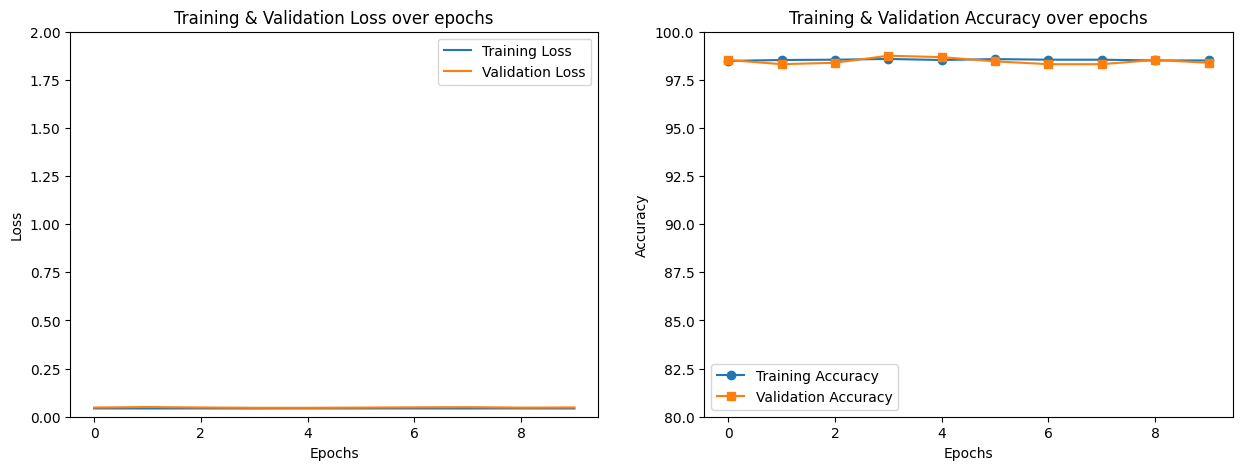

In [128]:
# data visualization

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_validation_plot, label = 'Validation Loss')
axs[0].set_title('Training & Validation Loss over epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()


axs[1].plot(total_acc_train_plot, 'o-', label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot, 's-', label = 'Validation Accuracy')
axs[1].set_title('Training & Validation Accuracy over epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([80, 100])
axs[1].legend()

plt.show()

In [124]:
print(total_acc_train_plot[:5])   # first 5 training accuracies
print(total_acc_validation_plot[:5])  # first 5 validation accuracies

[98.4838, 98.5309, 98.5466, 98.5859, 98.5309]
[98.5337, 98.3138, 98.3871, 98.7537, 98.6804]


In [132]:
Area = 342/original_df['Area'].abs().max()

MajorAxisLength = 654/original_df['MajorAxisLength'].abs().max()

MinorAxisLength = 385/original_df['MinorAxisLength'].abs().max()

Eccentricity = 452/original_df['Eccentricity'].abs().max()

ConvexArea = 754/original_df['ConvexArea'].abs().max()

EquivDiameter = 807/original_df['EquivDiameter'].abs().max()

Extent = 67/original_df['Extent'].abs().max()

Perimeter = 23/original_df['Perimeter'].abs().max()

Roundness = 90/original_df['Roundness'].abs().max()

AspectRation = 56/original_df['AspectRation'].abs().max()

my_prediction = model(torch.tensor([Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation], dtype = torch.float32).to(device))


In [133]:
my_prediction

tensor([1.], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [134]:
my_prediction.item()

1.0